In [1]:
from check_files import (
    basic_layout, check_basics, compile_study_df, create_df_descriptor, process_participant_data, process_event_data,
)
import os
import json
import time
import random
import concurrent.futures
from glob import glob
from wordcloud import WordCloud
from collections import Counter
from bids import BIDSLayout
from bids.exceptions import BIDSConflictingValuesError, BIDSValidationError
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# set dirs
dataset_dir = '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/openneuro_cloned/openneuro'
output_dir = "/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/openneuro_scrub/out_data"


# Basic Functions

In [3]:
def load_csv(filename, outdir):
    filepath = os.path.join(outdir, filename)
    if os.path.exists(filepath):
        return pd.read_csv(filepath)
    else:
        print(f"Missing: {filename}")
        return None

In [4]:
def process_study(open_neuro_id):
    print(f"Processing {open_neuro_id}...")  
    study_layout, study_subs, study_tasks, study_nonrest, study_runs, study_sessions, dir_type = basic_layout(dataset_dir, open_neuro_id)
    basics_df = check_basics(root_dir=dataset_dir, study=open_neuro_id)

    result = {
        "basics": basics_df,
        "compilesumm": None,
        "descriptor": None,
        "participant": None,
        "events": []
    }

    if study_layout != 'bids_error':
        result["compilesumm"] = compile_study_df(open_id=open_neuro_id, layout=study_layout, subs=study_subs, 
                                                 tasks=study_tasks, runs=study_runs, sessions=study_sessions, type_dir=dir_type)
        result["descriptor"] = create_df_descriptor(layout=study_layout, open_id=open_neuro_id)

        if bool(basics_df.loc[basics_df["file"] == "participants.tsv", "presence"].values[0]):
            part_json = bool(basics_df.loc[basics_df["file"] == "participants.json", "presence"].values[0])
            try:
                result["participant"] = process_participant_data(layout=study_layout, open_id=open_neuro_id, part_json_exists=part_json)
            except UnicodeDecodeError:
                print(f"Skipping {open_neuro_id} due to encoding error in participants.tsv")
            except Exception as e:
                print(f"Unexpected error processing {open_neuro_id}: {e}")

        if study_nonrest:
            for task_name in study_nonrest:
                try:
                    task_json = bool(basics_df.loc[basics_df["file"] == f"task-{task_name}_events.json", "presence"].values[0])
                    task_tsv = bool(basics_df.loc[basics_df["file"] == f"task-{task_name}_events.tsv", "presence"].values[0])
                    if task_tsv:
                        events_df = process_event_data(layout=study_layout, open_id=open_neuro_id, task=task_name, events_json_exists=task_json)
                        result["events"].append(events_df)
                except Exception as e:
                    print(f"Error obtaining events for {open_neuro_id}, task: {task_name}. See: {e}")
    
    return result

# Catalgue data from range of OP datasets

In [ ]:
all_basics = []
all_compilesumm = []
all_descriptors = []
all_participants = []
all_events = []

study_list = [d for d in os.listdir(dataset_dir) if d.startswith("ds") and os.path.isdir(os.path.join(dataset_dir, d))]

num_cpus= max(1, os.cpu_count() // 2)

with concurrent.futures.ThreadPoolExecutor(max_workers=num_cpus) as executor:
    results = list(executor.map(process_study, study_list))

# combine results across workers


Processing ds005238...Processing ds003799...

Processing ds004910...
Processing ds002674...
Processing ds005207...
Processing ds001653...
Processing ds003104...
Processing ds001461...
Processing ds002680...
Processing ds003752...
Processing ds004577...
Processing ds001839...
Processing ds004745...
Processing ds005697...
Processing ds004917...
Processing ds005469...
Processing ds004789...
Processing ds004742...
Processing ds002687...
Processing ds004114...
Processing ds004928...
Processing ds003103...
Basic Layout error: Conflicting values found for entity 'subject' in filename /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/openneuro_cloned/openneuro/ds004789/sub-R1001P/ses-0/beh/sub-R1001P_ses-0_task-FR1_beh.tsv (value='R1001P') versus its JSON sidecar (value='{'LongName': 'Subject ID', 'Description': 'The string identifier of the subject, e.g. R1001P.'}'). Please reconcile this discrepancy.
Processing ds004584...
Processing ds004579...
Processing ds005699..

In [41]:
all_basics = [result["basics"] for result in results if "basics" in result]
all_compilesumm = [result["compilesumm"] for result in results if "compilesumm" in result]
all_descriptors = [result["descriptor"] for result in results if "descriptor" in result]
all_participants = [result["participant"] for result in results if "participant" in result]
all_events = [event for result in results if "events" in result and isinstance(result["events"], list) for event in result["events"]]

# Step 3: Concatenate lists into DataFrames (handling empty lists properly)
all_basics_df = pd.concat(all_basics, ignore_index=True) if all_basics else pd.DataFrame()
all_compilesumm_df = pd.concat(all_compilesumm, ignore_index=True) if all_compilesumm else pd.DataFrame()
all_descriptors_df = pd.concat(all_descriptors, ignore_index=True) if all_descriptors else pd.DataFrame()
all_participants_df = pd.concat(all_participants, ignore_index=True) if all_participants else pd.DataFrame()
all_events_df = pd.concat(all_events, ignore_index=True) if all_events else pd.DataFrame()


In [42]:
# save final dfs
all_basics_df.to_csv(os.path.join(output_dir, "final_basics_summary.csv"), index=False)
all_compilesumm_df.to_csv(os.path.join(output_dir, "final_counts_summary.csv"), index=False)
all_descriptors_df.to_csv(os.path.join(output_dir, "final_descriptors.csv"), index=False)
all_participants_df.to_csv(os.path.join(output_dir, "final_participants.csv"), index=False)
all_events_df.to_csv(os.path.join(output_dir, "final_events.csv"), index=False)

## Aggregating & Plotting

In [4]:
all_basics = load_csv("final_basics_summary.csv", output_dir)
all_compilesumm = load_csv("final_counts_summary.csv", output_dir)
all_descriptors = load_csv("final_descriptors.csv", output_dir)
all_participants = load_csv("final_participants.csv", output_dir)
all_events = load_csv("final_events.csv", output_dir)


/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_34140/3491024193.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath)


In [5]:
study_list = [d for d in os.listdir(dataset_dir) if d.startswith("ds") and os.path.isdir(os.path.join(dataset_dir, d))]
n_studies = len(study_list)
print(f"Total OpenNeuro studies used in cataloging: {n_studies}")

Total OpenNeuro studies used in cataloging: 1288


In [6]:
bids_err_count = all_basics["presence"].astype(str).str.startswith("bids_").sum()
bids_percentage = (bids_err_count / n_studies) * 100 if n_studies > 0 else 0

print(f"Percentage studies encounteres some form of BIDS errors: {bids_percentage:.2f}% {bids_err_count} / {n_studies}")

Percentage studies encounteres some form of BIDS errors: 3.42% 44 / 1288


/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

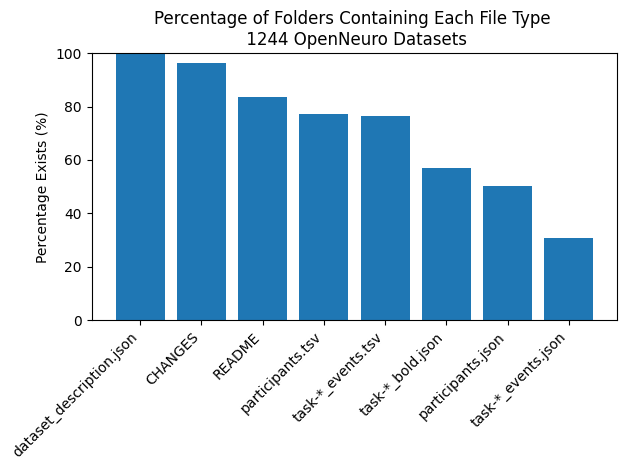

In [8]:
# Create new column based on 'file' column
all_basics["file_list"] = all_basics["file"].str.replace(
    r"(task-)[^_]+(_(events|bold)\.(tsv|json))", r"\1*\2", regex=True
)

all_basics["presence"] = pd.to_numeric(all_basics["presence"], errors="coerce")
percent_type = all_basics.groupby("file_list")["presence"].mean() * 100
percent_type = percent_type.reset_index()
percent_type.columns = ['type','percent']
percent_type = percent_type.sort_values(by="percent", ascending=False)

plt.bar(percent_type['type'], percent_type['percent'])
plt.xlabel('')
plt.ylabel('Percentage Exists (%)')
plt.title(f'Percentage of Folders Containing Each File Type \n {n_studies - bids_err_count} OpenNeuro Datasets')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [9]:
location_counts = all_basics.groupby(["file_list", "location"])["presence"].count().unstack(fill_value=0)
location_counts = location_counts.reset_index()
location_counts.loc[location_counts["file_list"] == "dataset_description.json", "missing"] = 10
print("Across all task and event files possible within dataset, file types across location")
location_counts

Across all task and event files possible within dataset, file types across location


location,file_list,func,missing,top
0,CHANGES,0,45,1199
1,README,0,202,1042
2,dataset_description.json,0,10,1244
3,participants.json,0,621,623
4,participants.tsv,0,283,961
5,task-*_bold.json,548,1028,819
6,task-*_events.json,268,1657,470
7,task-*_events.tsv,1731,563,101


In the below, the runs have a similar issue as sessions. The unique number of max numbers differs. Likewise, the max tasks differes, as it is not reflective to each task at a given session, rather the tasks labels across all administered.

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

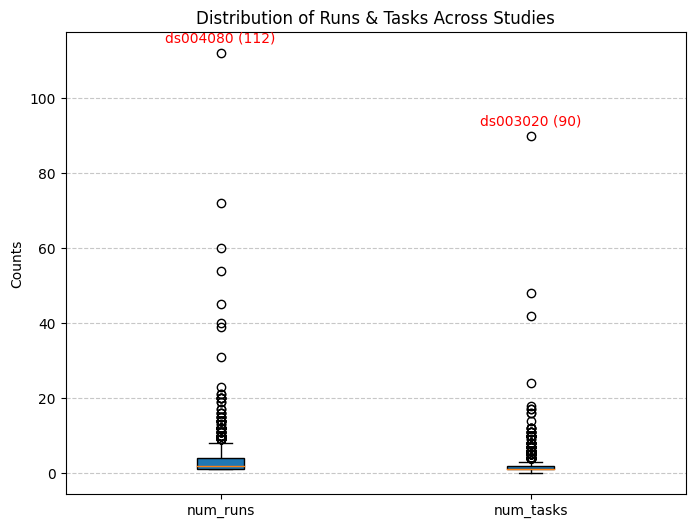

In [10]:
# Select relevant columns
data_to_plot = all_compilesumm[["num_runs", "num_tasks"]].dropna()

# Identify max values and corresponding study_id for each column
max_values = data_to_plot.max()
max_studies = {col: all_compilesumm.loc[all_compilesumm[col] == max_values[col], "study_id"].values
               for col in data_to_plot.columns}

# Create boxplot
plt.figure(figsize=(8, 6))
bp = plt.boxplot(data_to_plot.values, labels=data_to_plot.columns, patch_artist=True)

# Annotate max values with study_id, placing text slightly higher
for i, col in enumerate(data_to_plot.columns, start=1):
    max_value = max_values[col]
    max_study = ", ".join(max_studies[col])  # Convert list of study_ids to string
    plt.text(i, max_value + 2, f"{max_study} ({max_value})", 
             ha="center", va="bottom", fontsize=10, color="red", rotation=0)

# Add title and labels
plt.ylabel("Counts")
plt.title("Distribution of Runs & Tasks Across Studies")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

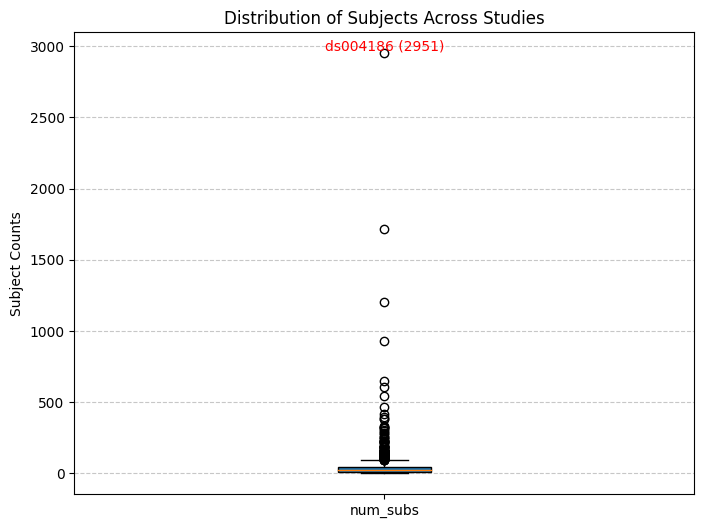

In [11]:
data_to_plot = all_compilesumm[["num_subs"]].dropna()

# Identify max value and corresponding study_id
max_value = data_to_plot["num_subs"].max()
max_study = all_compilesumm.loc[all_compilesumm["num_subs"] == max_value, "study_id"].values

# Create boxplot
plt.figure(figsize=(8, 6))
bp = plt.boxplot(data_to_plot.values, labels=data_to_plot.columns, patch_artist=True)

# Annotate the max value with study_id
plt.text(1, max_value, f"{', '.join(max_study)} ({max_value})", 
         ha="center", va="bottom", fontsize=10, color="red")

# Add title and labels
plt.ylabel("Subject Counts")
plt.title("Distribution of Subjects Across Studies")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

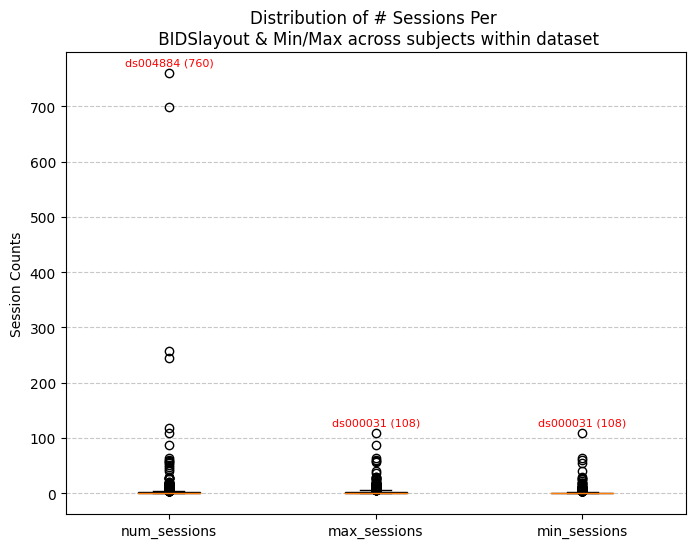

In [17]:
# Select relevant columns
data_to_plot = all_compilesumm[["num_sessions", "max_sessions", "min_sessions"]].dropna()

# Identify max values and corresponding study_id for each column
max_values = data_to_plot.max()
max_studies = {col: all_compilesumm.loc[all_compilesumm[col] == max_values[col], "study_id"].values
               for col in data_to_plot.columns}

# Create boxplot
plt.figure(figsize=(8, 6))
bp = plt.boxplot(data_to_plot.values, labels=data_to_plot.columns, patch_artist=True)

# Annotate max values with study_id
for i, col in enumerate(data_to_plot.columns, start=1):
    max_value = max_values[col]
    max_study = ", ".join(max_studies[col])  # Convert list of study_ids to string
    plt.text(i, max_value+10, f"{max_study} ({max_value})", 
             ha="center", va="bottom", fontsize=8, color="red", rotation=0)

# Add title and labels
plt.ylabel("Session Counts")
plt.title("Distribution of # Sessions Per \n BIDSlayout & Min/Max across subjects within dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

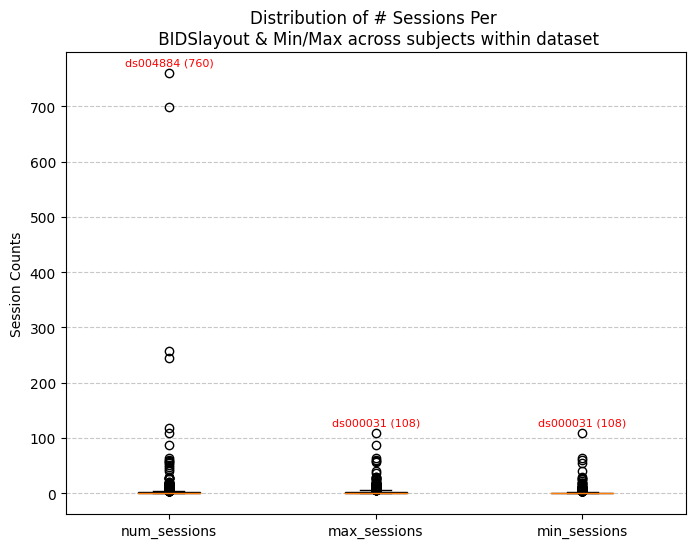

In [197]:
# Select relevant columns
data_to_plot = all_compilesumm[["num_sessions", "max_sessions", "min_sessions"]].dropna()

# Identify max values and corresponding study_id for each column
max_values = data_to_plot.max()
max_studies = {col: all_compilesumm.loc[all_compilesumm[col] == max_values[col], "study_id"].values
               for col in data_to_plot.columns}

# Create boxplot
plt.figure(figsize=(8, 6))
bp = plt.boxplot(data_to_plot.values, labels=data_to_plot.columns, patch_artist=True)

# Annotate max values with study_id
for i, col in enumerate(data_to_plot.columns, start=1):
    max_value = max_values[col]
    max_study = ", ".join(max_studies[col])  # Convert list of study_ids to string
    plt.text(i, max_value+10, f"{max_study} ({max_value})", 
             ha="center", va="bottom", fontsize=8, color="red", rotation=0)

# Add title and labels
plt.ylabel("Session Counts")
plt.title("Distribution of # Sessions Per \n BIDSlayout & Min/Max across subjects within dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


In [18]:
root_type_counts = all_compilesumm["root_type"].value_counts()
root_type_counts.reset_index()
root_type_counts


root_type
bids_input         1242
bids_derivative       1
Name: count, dtype: int64

In [ ]:
total_studies = len(all_compilesumm)

# create how many non-rest tasks:
all_compilesumm["n_nonrest-task"] = all_compilesumm["nonrest_tasks"].apply(
    lambda x: 0 if x == "[]" else 1
)

# Calculate percentages
rev_tasks_percent = all_compilesumm["n_nonrest-task"].gt(0).sum() / total_studies * 100
bold_exists_percent = all_compilesumm["bold_exists"].sum() / total_studies * 100
rev_tasks_in_bold_percent = (
    all_compilesumm.loc[all_compilesumm["bold_exists"], "n_nonrest-task"].gt(0).sum()
    / all_compilesumm["bold_exists"].sum()
    * 100
)

# % of non-rest tasks with events
nonrest_task = all_compilesumm[(all_compilesumm["n_nonrest-task"] == 1)]

nonrest_task_w_events_percent = (
    nonrest_task.loc[nonrest_task["n_nonrest-task"].gt(0), "events_exists"].sum()
    / nonrest_task["n_nonrest-task"].gt(0).sum()
    * 100
)

# % of studies with BOLD Task w events
bold_subset = all_compilesumm[(all_compilesumm["bold_exists"] == 1) & (all_compilesumm["n_nonrest-task"] == 1)]
bold_nonrest_with_events_percent = (
    bold_subset.loc[bold_subset["n_nonrest-task"].gt(0), "events_exists"].sum()
    / bold_subset["n_nonrest-task"].gt(0).sum()
    * 100
)

# Labels and values
labels = [
    "% w/ Tasks",
    "% w/ Bold",
    "% BOLD w/ Tasks",
    "% Tasks w/ Events",
    "% BOLD Task w/ Events",
]
values = [
    rev_tasks_percent,
    bold_exists_percent,
    rev_tasks_in_bold_percent,
    nonrest_task_w_events_percent,
    bold_nonrest_with_events_percent,
]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=["blue", "green", "orange", "red", "purple"])
plt.ylabel("Percentage (%)")
plt.title(f"Percentage of Studies with \n Tasks, BOLD, Events files from Total: \n {total_studies}")
plt.ylim(0, 100)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


## 

## Summarizing dataset descriptor files

### Freq of Keys

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

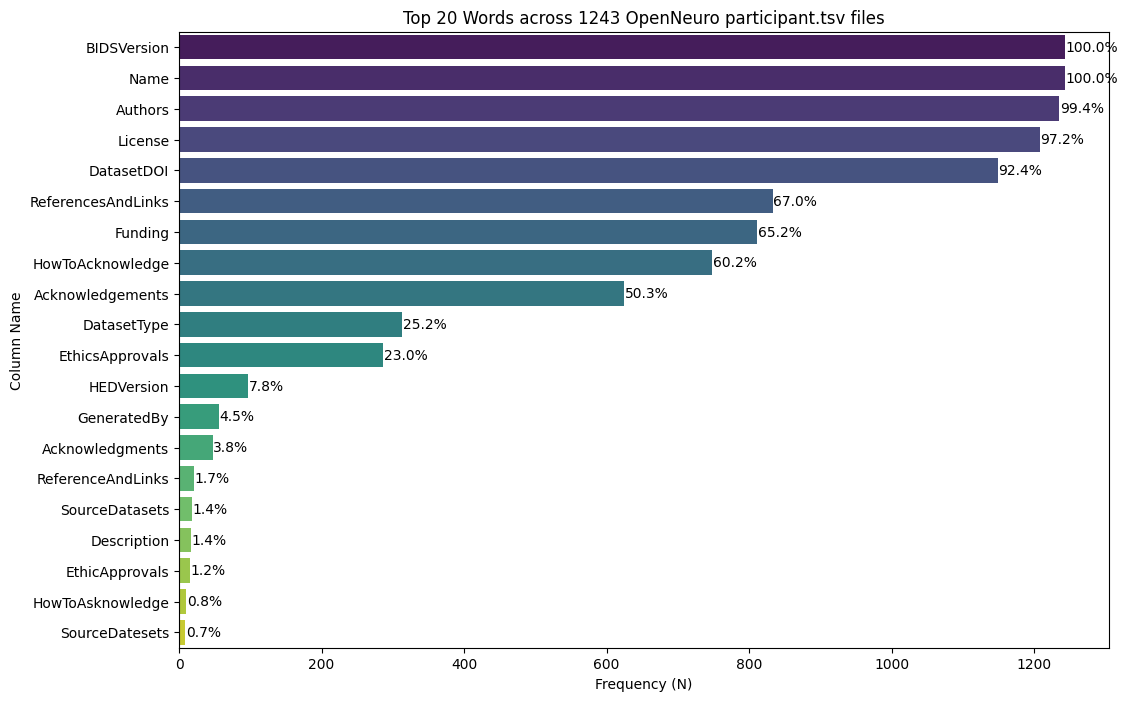

In [ ]:
uniq_studies = all_descriptors['study_id'].unique()
total_studies = len(uniq_studies)

# fre words, pick top
top_n_words = 20
freq_words = Counter(all_descriptors['key'])
top_words = freq_words.most_common(top_n_words)
top_words_df = pd.DataFrame(top_words, columns=['name', 'freq'])

# Compute the percentage relative to uniq studies
top_words_df['percent'] = (top_words_df['freq'] / total_studies) * 100

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Top {top_n_words} Words across {total_studies} OpenNeuro participant.tsv files')

plt.xlabel('Frequency (N)')
plt.ylabel('Column Name')

# Display percentages on the bars
for i, (freq, percent) in enumerate(zip(top_words_df['freq'], top_words_df['percent'])):
    plt.text(freq + 1, i, f'{percent:.1f}%', va='center', fontsize=10)

plt.show()


## Participants

### Freq cols in participants

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

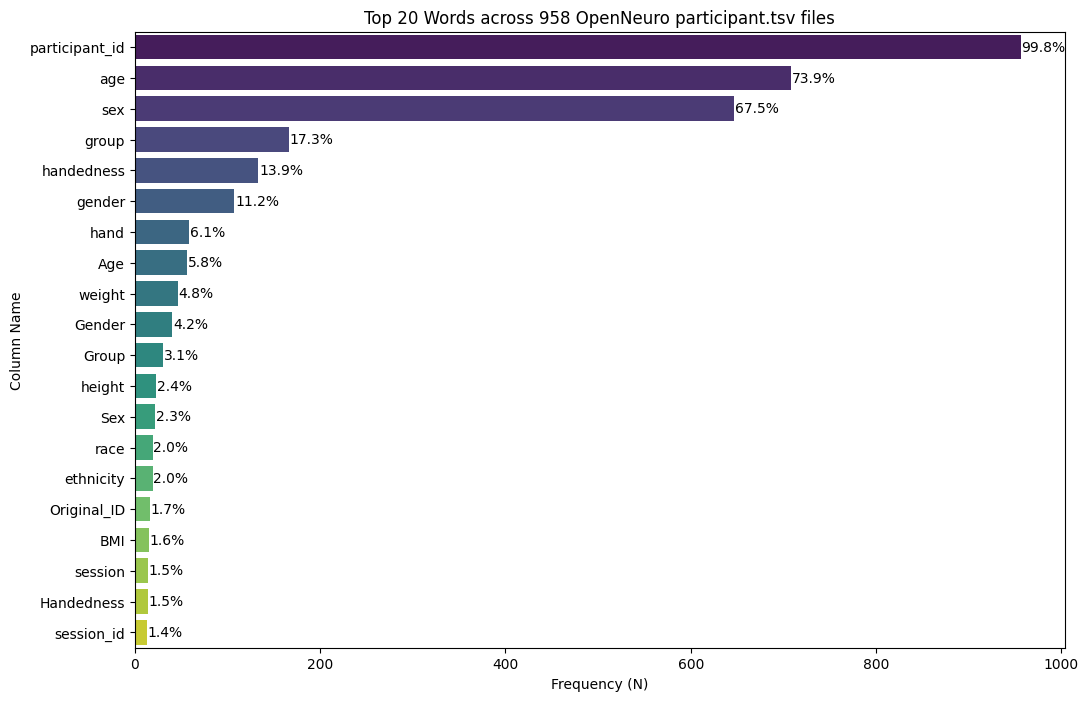

In [ ]:
# Remove duplicate for study and key pairs. Repeating for values,s o dont want in % est
unique_participants = all_participants[['study_id', 'key']].drop_duplicates()

# get uniq study counts, count freq words and subset by specified N
uniq_studies = unique_participants['study_id'].unique()
total_studies = len(uniq_studies)
freq_words = Counter(unique_participants['key'])
top_n_words = 20
top_words = freq_words.most_common(top_n_words)
top_words_df = pd.DataFrame(top_words, columns=['name', 'freq'])

# % est per key
top_words_df['percent'] = (top_words_df['freq'] / total_studies) * 100

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')

plt.title(f'Top {top_n_words} Words across {total_studies} OpenNeuro participant.tsv files')

plt.xlabel('Frequency (N)')
plt.ylabel('Column Name')

# add %
for i, (freq, percent) in enumerate(zip(top_words_df['freq'], top_words_df['percent'])):
    plt.text(freq + 1, i, f'{percent:.1f}%', va='center', fontsize=10)

plt.show()


### Freq top N cols in json keys

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

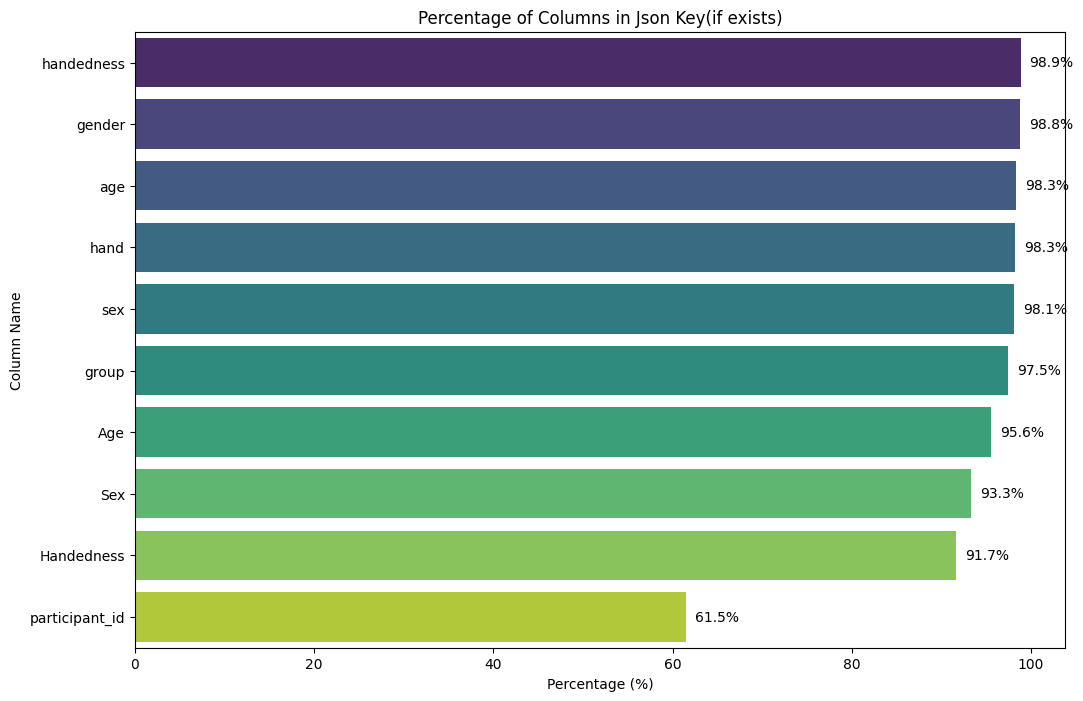

In [53]:
# subset IDs
keys_to_keep = ['participant_id', 'sex', 'Sex', 'gender', 'gender', 'age', 'Age', 'group','handedness','hand','Handedness']
filtered_partkeys = all_participants[all_participants['key'].isin(keys_to_keep)].copy()
filtered_partkeys = filtered_partkeys[['study_id', 'key', 'partkeys_in_json']].drop_duplicates()

# drop rows w/ partkeys_in_json is 'json_notavailable' & make 0/1 numeric
filtered_partkeys = filtered_partkeys[filtered_partkeys['partkeys_in_json'] != "json_notavailable"]
filtered_partkeys['partkeys_in_json'] = filtered_partkeys['partkeys_in_json'].astype(int)

key_counts = filtered_partkeys.groupby('key')['partkeys_in_json'].sum()
total_counts = filtered_partkeys.groupby('key')['study_id'].nunique()
percentages = (key_counts / total_counts) * 100

# Create DataFrame for plotting
plot_df = pd.DataFrame({'key': percentages.index, 'percent': percentages.values})

# Sort by percentage (descending)
plot_df = plot_df.sort_values(by='percent', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_df, y='key', x='percent', palette='viridis')

plt.title('Percentage of Columns in Json Key(if exists)')
plt.xlabel('Percentage (%)')
plt.ylabel('Column Name')

# Display percentage on the bars
for i, (percent, key) in enumerate(zip(plot_df['percent'], plot_df['key'])):
    plt.text(percent + 1, i, f'{percent:.1f}%', va='center', fontsize=10)

plt.show()


## Events files

### Freq top N cols in events file

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

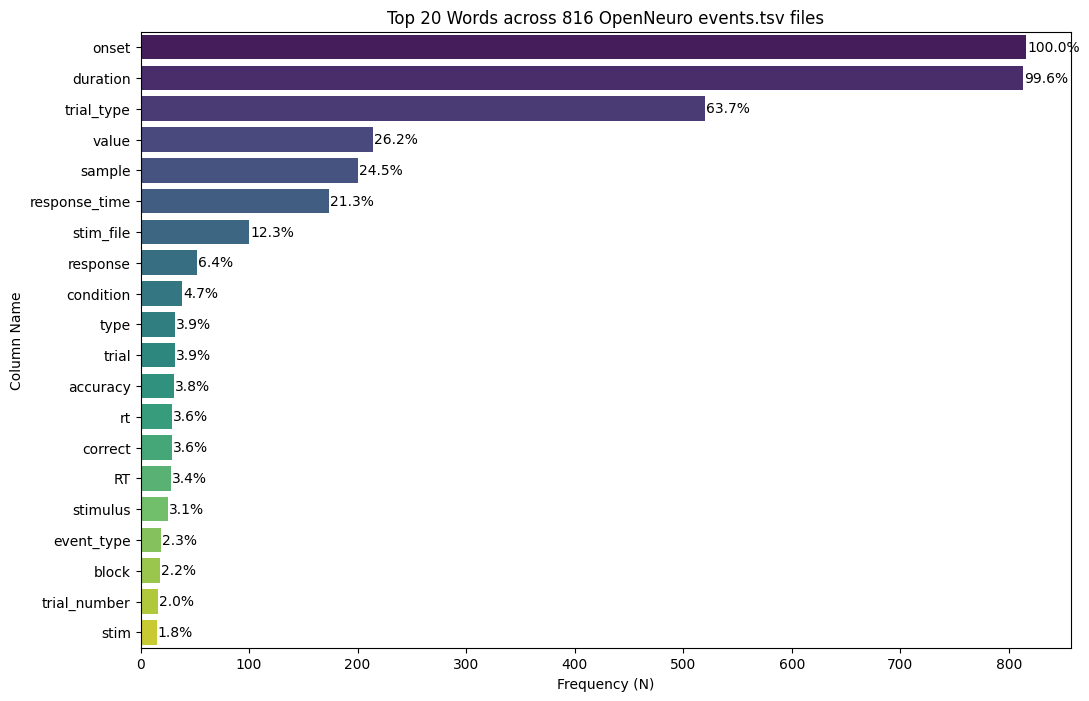

In [44]:
# Remove duplicate for study and key pairs. Repeating for values,s o dont want in % est
unique_participants = all_events[['study_id', 'key']].drop_duplicates()

# get uniq study counts, count freq words and subset by specified N
uniq_studies = unique_participants['study_id'].unique()
total_studies = len(uniq_studies)
freq_words = Counter(unique_participants['key'])
top_n_words = 20
top_words = freq_words.most_common(top_n_words)
top_words_df = pd.DataFrame(top_words, columns=['name', 'freq'])

# % est per key
top_words_df['percent'] = (top_words_df['freq'] / total_studies) * 100

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')

plt.title(f'Top {top_n_words} Words across {total_studies} OpenNeuro events.tsv files')

plt.xlabel('Frequency (N)')
plt.ylabel('Column Name')

# add %
for i, (freq, percent) in enumerate(zip(top_words_df['freq'], top_words_df['percent'])):
    plt.text(freq + 1, i, f'{percent:.1f}%', va='center', fontsize=10)

plt.show()


### % when value in json container if it exists

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/demidenm/miniconda3/envs/brain_env/lib/pyth

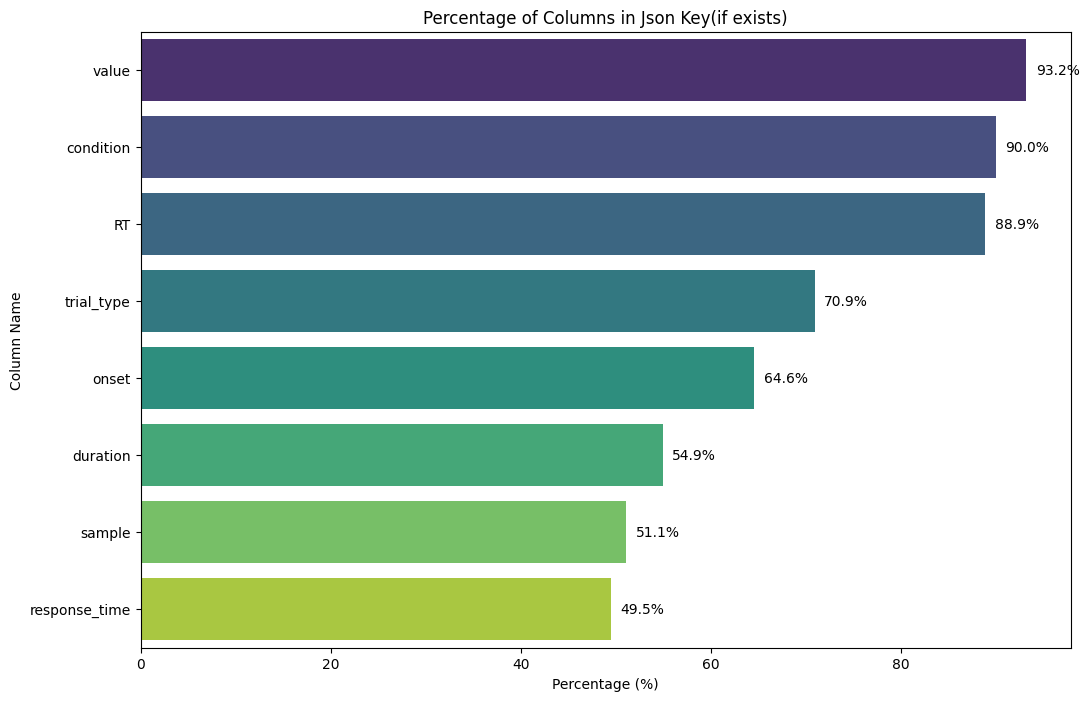

In [ ]:
# subset IDs
keys_to_keep = ['onset', 'duration', 'trial_type', 'value', 'sample', 'response_time', 'RT', 'condition']
filtered_partkeys = all_events[all_events['key'].isin(keys_to_keep)].copy()
filtered_partkeys = filtered_partkeys[['study_id', 'key', 'eventkeys_in_json']].drop_duplicates()

# drop rows w/ partkeys_in_json is 'json_notavailable' & make 0/1 numeric
filtered_partkeys = filtered_partkeys[filtered_partkeys['eventkeys_in_json'] != "json_notavailable"]
filtered_partkeys['eventkeys_in_json'] = filtered_partkeys['eventkeys_in_json'].astype(int)

key_counts = filtered_partkeys.groupby('key')['eventkeys_in_json'].sum()
total_counts = filtered_partkeys.groupby('key')['study_id'].nunique()
percentages = (key_counts / total_counts) * 100

# Create DataFrame for plotting
plot_df = pd.DataFrame({'key': percentages.index, 'percent': percentages.values})

# Sort by percentage (descending)
plot_df = plot_df.sort_values(by='percent', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_df, y='key', x='percent', palette='viridis')

plt.title('Percentage of Columns in Json Key (if exists)')
plt.xlabel('Percentage (%)')
plt.ylabel('Column Name')

# Display percentage on the bars
for i, (percent, key) in enumerate(zip(plot_df['percent'], plot_df['key'])):
    plt.text(percent + 1, i, f'{percent:.1f}%', va='center', fontsize=10)

plt.show()

## Define Some functions

In [ ]:
def get_descriptor_data(bids_path, task_name):
    descriptor_file = os.path.join(bids_path, f'task-{task_name}_events.json')
    if os.path.exists(descriptor_file):
        with open(descriptor_file, 'r') as file:
            descriptor_data = json.load(file)
            
        return True, descriptor_data 
    else:
        return False, None
    
def exist_datadesc_part_files(bids_path):

    part_json = os.path.exists(f'{bids_path}/participants.json')
    part_tsv = os.path.exists(f'{bids_path}/participants.tsv')
    datadesc_json = os.path.exists(f'{bids_path}/dataset_description.json')

    return datadesc_json, part_json, part_tsv

def exist_bold_nonrest(bids_layout):
    # does BOLD data exist, if not, skip.
    files = bids_layout.get(suffix='bold', extension='.nii.gz')
    if not files: 
        return False, None
    
    # are non-rest tasks present?
    list_tasks = bids_layout.get_tasks()
    if all(task in ['rest', 'resting'] for task in list_tasks):
        return True, False
    
    return True, True
        

def extract_info_from_path(path):
    base_file_noext = os.path.splitext(os.path.basename(path))[0]
    sub_parts = base_file_noext.split('_')
    
    # extract sub-, ses-, task-, and run- info details
    sub_id = next((part.split('-')[1] for part in sub_parts if part.startswith('sub-')), None)
    ses_num = next((part.split('-')[1] for part in sub_parts if part.startswith('ses-')), None)
    task_lab = next((part.split('-')[1] for part in sub_parts if part.startswith('task-')), None)
    run_num = next((part.split('-')[1] for part in sub_parts if part.startswith('run-')), None)
    
    return sub_id, ses_num, task_lab, run_num


def get_events_df(bids_layout, sub, task, sess=None, run=None):
    time.sleep(1)

    kwargs = {'subject': sub, 'task': task, 'suffix': 'events', 'extension': '.tsv', 'return_type': 'filename'}
    if sess is not None:
        kwargs['session'] = sess
    if run is not None:
        kwargs['run'] = run
    
    try:
        result = bids_layout.get(**kwargs)
        
        if not result or len(result) == 0:
            return None
        
        print(f"File retrieved for {kwargs}")
        file_path = result[0]
        return pd.read_csv(file_path, sep='\t')
    
    except Exception as e:
        print(f"Error retrieving or reading file for {kwargs}: {e}")
        return None


def process_events(pd_events, study_id, taskname, subj_id, sess_id, run_id, task_descriptor_info):
    if pd_events is not None:
        try:
            events_vals = check_columns_in_events(sub_event_df=pd_events, data_task_descriptor=task_descriptor_info)
            events_vals['study'] = study_id
            events_vals['subject'] = subj_id
            events_vals['session'] = sess_id
            events_vals['run'] = run_id
            events_vals['task'] = taskname
            return events_vals
        except Exception as e:
            print(f"Error processing events data")
    else:
        print(f"No File Present")

# 1. Availability of three primary files

In [138]:
outdata ='/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro'
opne_folders = glob(f'{outdata}/*')
len(opne_folders)


1109

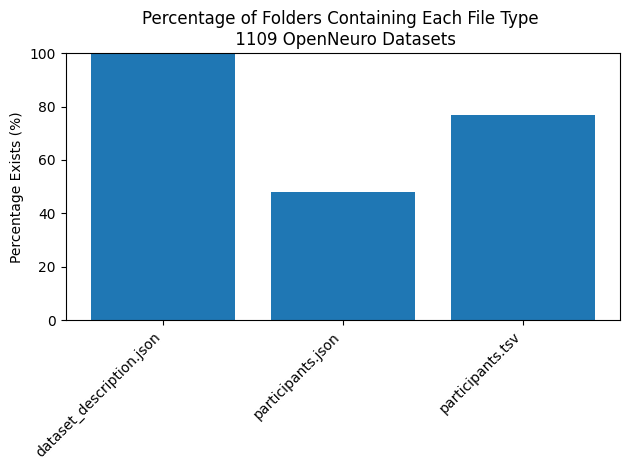

In [140]:
percent_type = file_existence_df.groupby('type')['exists'].mean() * 100
percent_type = percent_type.reset_index()
percent_type.columns = ['type','percent']
plt.bar(percent_type['type'], percent_type['percent'])
plt.xlabel('')
plt.ylabel('Percentage Exists (%)')
plt.title(f'Percentage of Folders Containing Each File Type \n {len(opne_folders)} OpenNeuro Datasets')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# 2. Column Types and Frequency in Participants.tsv

In [141]:
file_list = glob(f'{outdata}/**/participants.tsv')
len(file_list)

848

In [142]:
columns_df = participant_col_list(file_list)

b'Skipping line 14: expected 16 fields, saw 17\n'
b'Skipping line 14: expected 16 fields, saw 17\n'


### Word cloud of words in columns

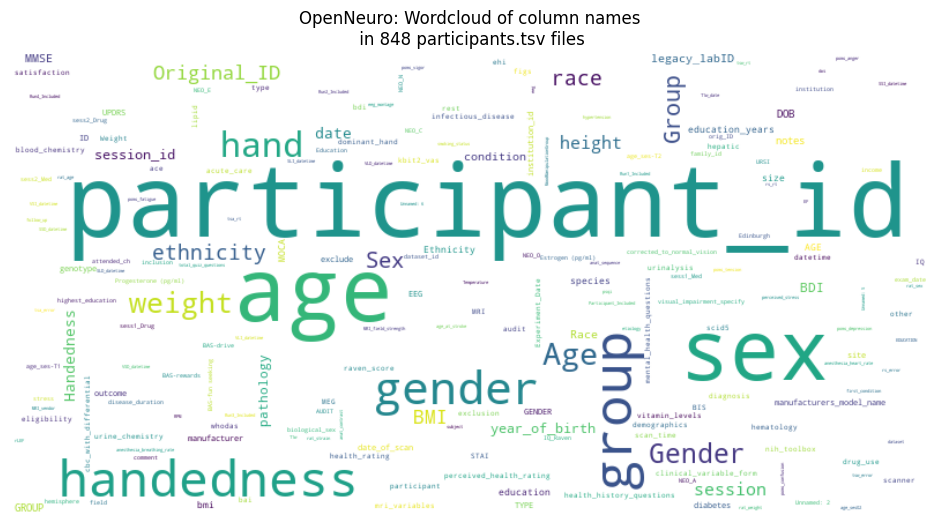

In [143]:
freq_words = Counter(columns_df['column_name'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(freq_words)

# Plot the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'OpenNeuro: Wordcloud of column names \n in {len(file_list)} participants.tsv files ')
plt.show()

### Frequency of words for the top 20 words

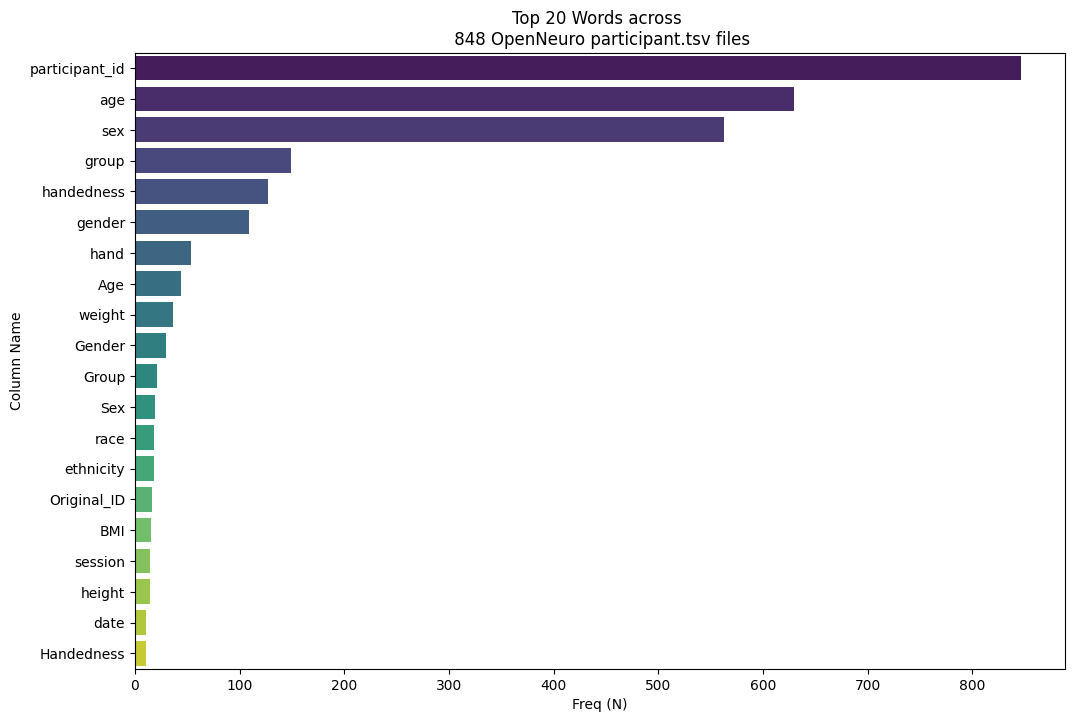

In [144]:
freq_words = Counter(columns_df['column_name'])

# pick top 25
top_25_words = dict(freq_words.most_common(20))
top_words_df = pd.DataFrame(list(top_25_words.items()), columns=['name', 'freq'])


plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Top 20 Words across \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Column Name')
plt.show()

# 3. Types of Values for primary columns

In [145]:
columns_name_eval = ['age','sex','gender','handedness','hand']
columns_values_df = participant_col_values(file_list,columns_name_eval)

b'Skipping line 14: expected 16 fields, saw 17\n'
b'Skipping line 14: expected 16 fields, saw 17\n'


In [146]:
sex_values = columns_values_df[columns_values_df['column_name']=='sex']
gender_values = columns_values_df[columns_values_df['column_name']=='gender']
handedness = columns_values_df[columns_values_df['column_name']=='handedness']

### Frequncy of values for sex/Sex columns

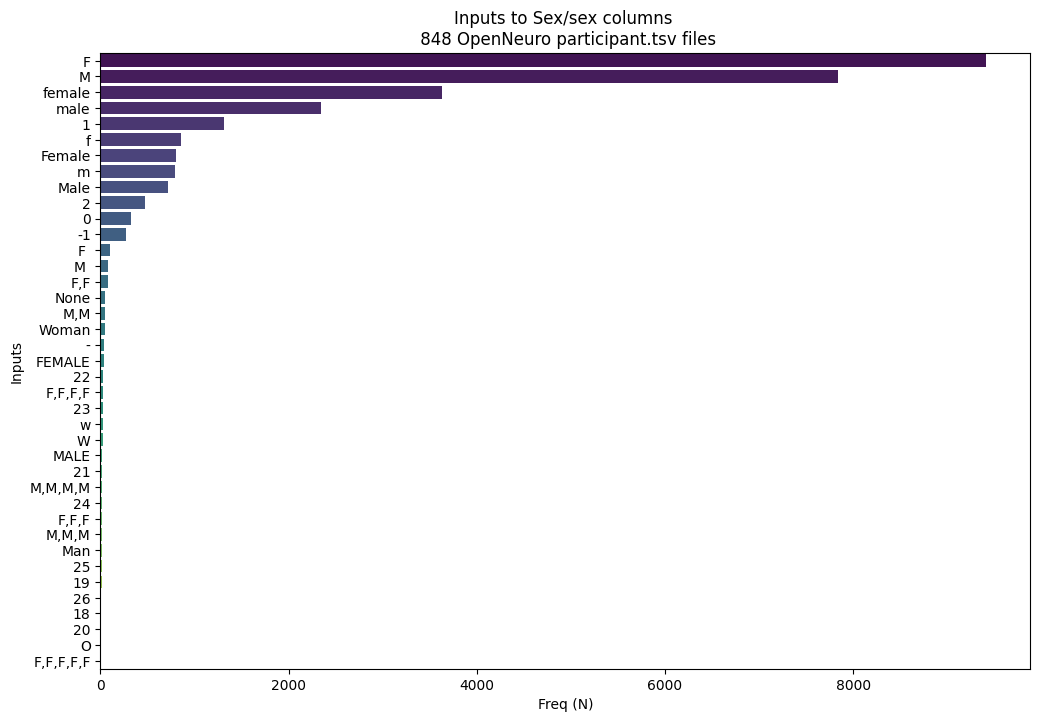

In [147]:
freq_words = Counter(sex_values['values'])

# pick top 40
top_40_words = dict(freq_words.most_common(40))

top_words_df = pd.DataFrame(list(top_40_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to Sex/sex columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Frequncy of values for Gender/gender columns

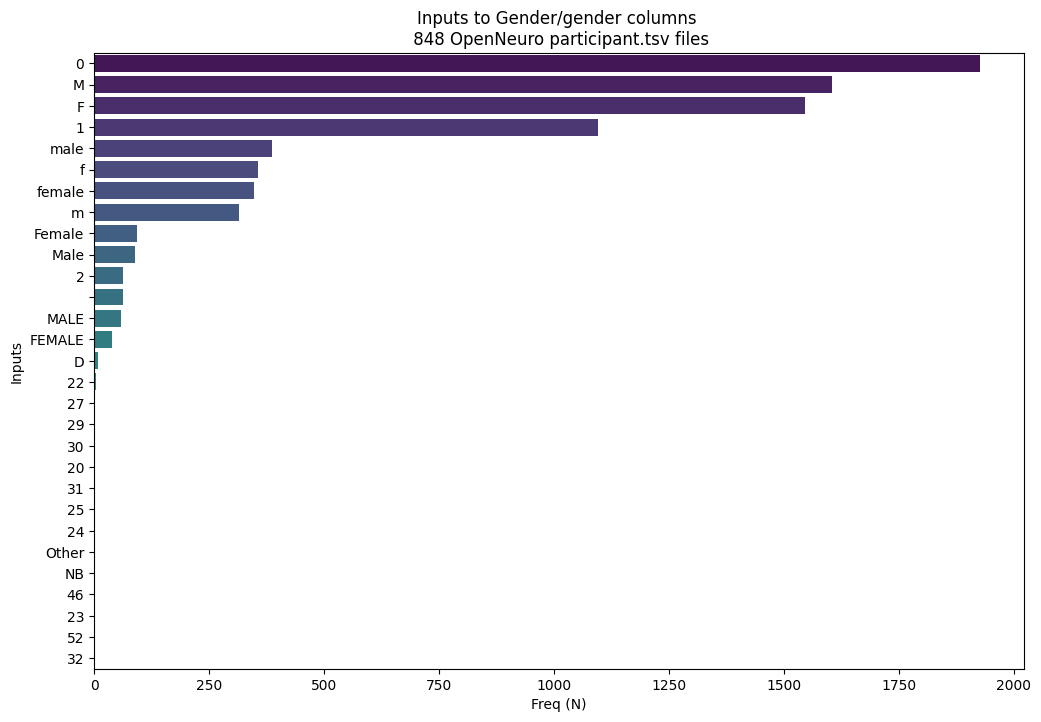

In [148]:
freq_words = Counter(gender_values['values'])

# pick top 30
top_30_words = dict(freq_words.most_common(30))

top_words_df = pd.DataFrame(list(top_30_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to Gender/gender columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Frequncy of values for Handedness/handedness columns

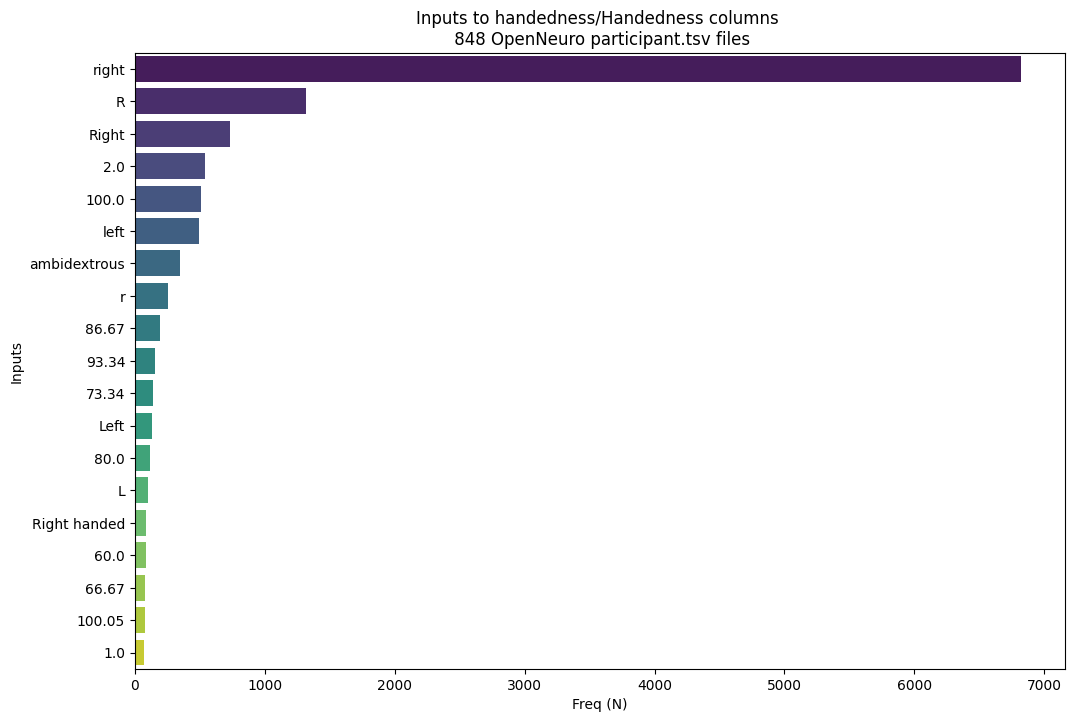

In [149]:
freq_words = Counter(handedness['values'])

top_20_words = dict(freq_words.most_common(20))

top_words_df = pd.DataFrame(list(top_20_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to handedness/Handedness columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Inspecting `int` when Expecting `str`

A number of the string variables, such as sex, gender and handedness, have intergers included. Is this a coding error on my part or a data issue?

In [150]:
gender_values[gender_values['values'].apply(lambda x: isinstance(x, int))].sort_values('values')

,study_id,column_name,values
18740,ds003424,gender,0
56299,ds004186,gender,0
56300,ds004186,gender,0
56301,ds004186,gender,0
56302,ds004186,gender,0
...,...,...,...
58163,ds003357,gender,38
58154,ds003357,gender,46
58176,ds003357,gender,51
58157,ds003357,gender,52


Reviewing the above dataset `ds003357`, as it is [available on OpenNeuro](https://openneuro.org/datasets/ds003357/versions/1.0.0/file-display/participants.tsv) there are column names/labels that are flipped. For example gender <--> age. Which is a think that occurs in some other datasets, too.

In [151]:
pd.read_csv('/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds003357/participants.tsv',
            sep='\t')

,participant_id,group,gender,age
0,sub-01,biofeedback,31,F
1,sub-02,biofeedback,22,F
2,sub-03,biofeedback,25,F
3,sub-04,biofeedback,46,M
4,sub-05,biofeedback,27,F
5,sub-06,biofeedback,23,M
6,sub-07,biofeedback,52,M
7,sub-08,biofeedback,29,M
8,sub-09,biofeedback,27,M
9,sub-10,biofeedback,32,F


## Checking File Contents & Sub/Run/Sess Ns

In [6]:
dir_list = glob('/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/*/')
len(dir_list)

1109

In [9]:
study_info_general = []
combined_dataframes = []
counter = 0

for study_dir in dir_list:
    counter = counter + 1
    print('#',counter, study_dir)

    study_name = os.path.basename(os.path.dirname(study_dir))
    datadesc_exist, partjson_exist, parttsv_exist = exist_datadesc_part_files(os.path.dirname(study_dir))
    try:
        layout_study = BIDSLayout(study_dir)
        study_subs = layout_study.get_subjects()
        study_tasks = layout_study.get_tasks()
        study_runs = layout_study.get_runs()
        study_sess = layout_study.get_sessions()
        bold_exist, nonrest_exist= exist_bold_nonrest(
            bids_layout=layout_study
        )

        study_tasks_nonrest = [task for task in layout_study.get_tasks() if task not in ['rest', 'resting']]


        task_labels_list = []
        descriptor_exists_list = []

        if nonrest_exist:
            for tasklab in study_tasks_nonrest:
                descriptor_exists, descriptor_data = get_descriptor_data(bids_path=study_dir,
                                                                        task_name = tasklab)
                task_labels_list.append(tasklab)
                descriptor_exists_list.append(descriptor_exists)

                if descriptor_exists:
                    for sub in study_subs:
                        sub_events_list = layout_study.get(subject=sub, task=tasklab, suffix= 'events', extension= '.tsv', 
                                                        return_type='filename')
                        for sub_file in sub_events_list:
                            _,ses_num,_,run_num = extract_info_from_path(sub_file[0])
                            sub_events_df = pd.read_csv(sub_file, sep='\t')

                            check_eventstaskdesc_pd = process_events(pd_events=sub_events_df, task_descriptor_info=descriptor_data,
                                                                    study_id=study_name, taskname=tasklab,
                                                                    subj_id=sub, sess_id=ses_num, run_id=run_num)
                            
                            combined_dataframes.append(check_eventstaskdesc_pd)
        

        study_info_general.append({
                            'study_name': study_name,
                            'num_subs': len(study_subs) if study_subs else None,
                            'num_sess': len(study_sess) if study_sess else "1",
                            'num_runs': len(study_runs) if study_runs else "1",
                            'bold_exists': bold_exist,
                            'nonrest_exists': nonrest_exist,
                            'num_non-rest_tasks': len(study_tasks_nonrest) if study_tasks_nonrest else None,
                            'task_list': task_labels_list if task_labels_list else None,
                            'task_decsriptor_exist': descriptor_exists_list if descriptor_exists_list else None, 
                            'datadesc_exist': datadesc_exist,
                            'partic_json_exist': partjson_exist,
                            'participant_tsv_exist': parttsv_exist,
                            'error_messages': None,
                        })
    except (OSError, BIDSConflictingValuesError, BIDSValidationError, UnicodeDecodeError) as e:
        print("Error for study:", study_name)
        study_info_general.append({
                            'study_name': study_name,
                            'num_subs': None,
                            'nuum_sess': None,
                            'num_runs': None,
                            'bold_exists': None,
                            'nonrest_exists': None,
                            'num_non-rest_tasks': None,
                            'task_list': None,
                            'task_decsriptor_exist': None, 
                            'datadesc_exist': None,
                            'partic_json_exist': None,
                            'participant_tsv_exist': None,
                            'error_messages': str(e).replace('\t', '').replace(',', '') # to avoid csv/tsv parse issues
                        })


# 1 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds003799/
# 2 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds004910/
# 3 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds002674/
# 4 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds001653/
# 5 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds003104/
# 6 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds001461/
# 7 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds002680/
# 8 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds003752/
# 9 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds004577/
# 10 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds001839/
# 11 /Users/demidenm/Desktop/Academia/Stanford/9_

In [10]:
final_combined_df = pd.concat(combined_dataframes, ignore_index=True)
final_study_info = pd.DataFrame(study_info_general)
final_combined_df.to_csv('/Users/demidenm/Downloads/final_study_combined_checks.tsv', sep='\t')
final_study_info.to_csv('/Users/demidenm/Downloads/final_study_details.tsv', sep='\t')

# Plotting some results from combined evevts + study info

In [3]:
final_combined_df = pd.read_csv('/Users/demidenm/Downloads/final_study_combined_checks.tsv', sep='\t', low_memory=False)
final_study_info = pd.read_csv('/Users/demidenm/Downloads/final_study_details.tsv', sep='\t', low_memory=False)

In [4]:
final_study_info.columns

Index(['Unnamed: 0', 'study_name', 'num_subs', 'nuum_sess', 'num_runs',
       'bold_exists', 'nonrest_exists', 'num_non-rest_tasks', 'task_list',
       'task_decsriptor_exist', 'datadesc_exist', 'partic_json_exist',
       'participant_tsv_exist', 'error_messages'],
      dtype='object')

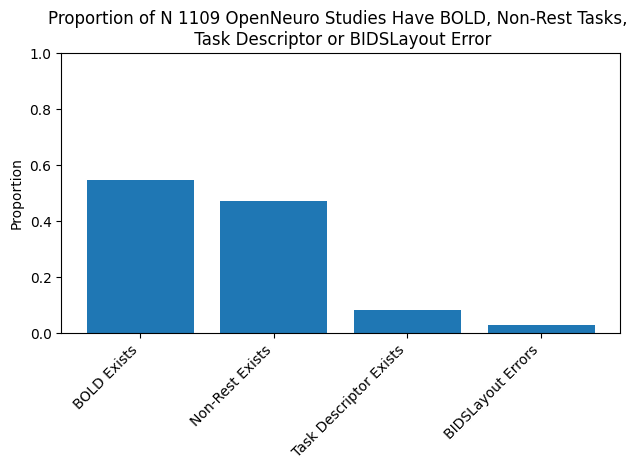

In [11]:
total_n = len(final_study_info)
bids_layouterror = final_study_info['error_messages'].notna().sum() / total_n
bold_proportion = final_study_info['bold_exists'].sum() / total_n
nonrest_proportion = final_study_info['nonrest_exists'].sum() / total_n
task_descr_exist = final_study_info['task_decsriptor_exist'].dropna().apply(lambda x: any(x)).astype(bool).sum() / total_n

plt.bar(['BOLD Exists', 'Non-Rest Exists', 'Task Descriptor Exists', 'BIDSLayout Errors'], 
        [bold_proportion, nonrest_proportion, task_descr_exist, bids_layouterror])
plt.ylabel('Proportion')
plt.title(f'Proportion of N {len(final_study_info)} OpenNeuro Studies Have BOLD, Non-Rest Tasks, \n Task Descriptor or BIDSLayout Error')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



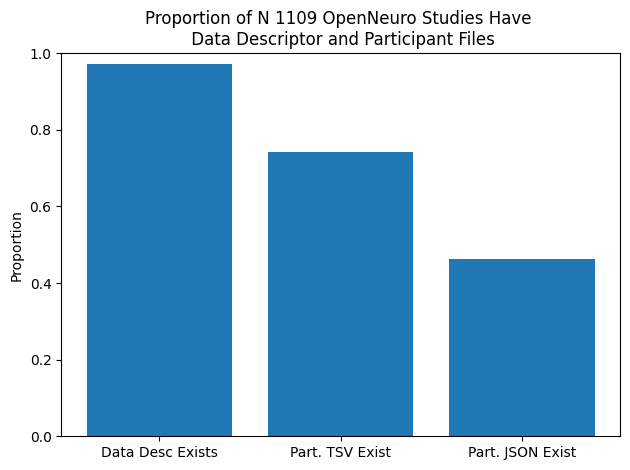

In [12]:
datdesc_proportion = final_study_info['datadesc_exist'].sum() / total_n
partici_json_proportion = final_study_info['partic_json_exist'].sum() / total_n
participant_tsv_proportion = final_study_info['participant_tsv_exist'].sum() / total_n

plt.bar(['Data Desc Exists', 'Part. TSV Exist', 'Part. JSON Exist', ],
        [datdesc_proportion, participant_tsv_proportion, partici_json_proportion])
plt.ylabel('Proportion')
plt.title(f'Proportion of N {len(final_study_info)} OpenNeuro Studies Have \n Data Descriptor and Participant Files')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

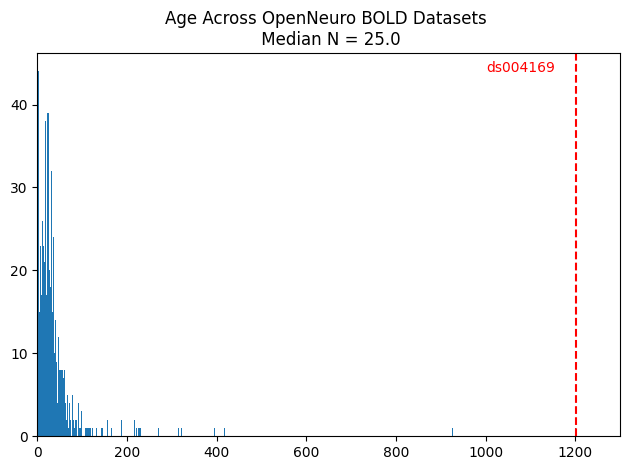

In [13]:
filtered_data = final_study_info[final_study_info['nonrest_exists'] == True]

plt.hist(filtered_data['num_subs'], bins=500)
max_subs = filtered_data['num_subs'].max()
max_label = filtered_data.loc[filtered_data['num_subs'] == max_subs, 'study_name'].values[0]
plt.axvline(max_subs, color='r', linestyle='--')
plt.text(max_subs-200, plt.ylim()[1]*0.95, f'{max_label}', color='r')
plt.xlim(0,1300)
plt.title(f'Age Across OpenNeuro BOLD Datasets \n Median N = {filtered_data["num_subs"].median()}')
plt.tight_layout()
plt.show()

/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_54522/2832325334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['nuum_sess'] = filtered_data['nuum_sess'].fillna(0).astype(int)


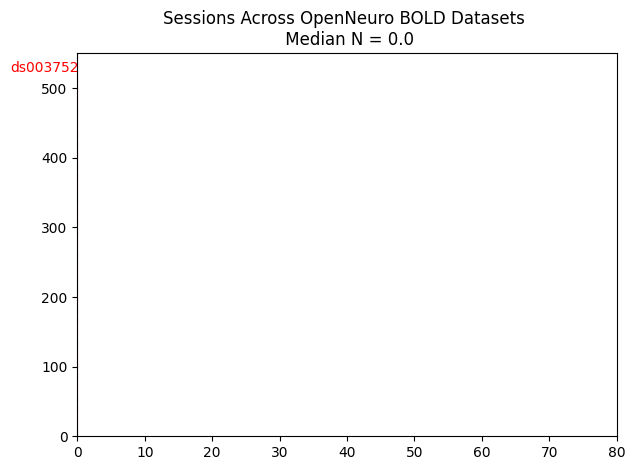

In [14]:
filtered_data['nuum_sess'] = filtered_data['nuum_sess'].fillna(0).astype(int)

plt.hist(filtered_data['nuum_sess'], bins=50)
max_sess = filtered_data['nuum_sess'].max()
max_label = filtered_data.loc[filtered_data['nuum_sess'] == max_sess, 'study_name'].values[0]
plt.xlim(0,80)
plt.axvline(max_sess, color='r', linestyle='--')
plt.text(max_sess-10, plt.ylim()[1]*0.95, f'{max_label}', color='r')

plt.title(f'Sessions Across OpenNeuro BOLD Datasets \n Median N = {filtered_data["nuum_sess"].median()}')
plt.tight_layout()
plt.show()

/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_54522/2609117738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['num_runs'] = filtered_data['num_runs'].fillna(0).astype(int)


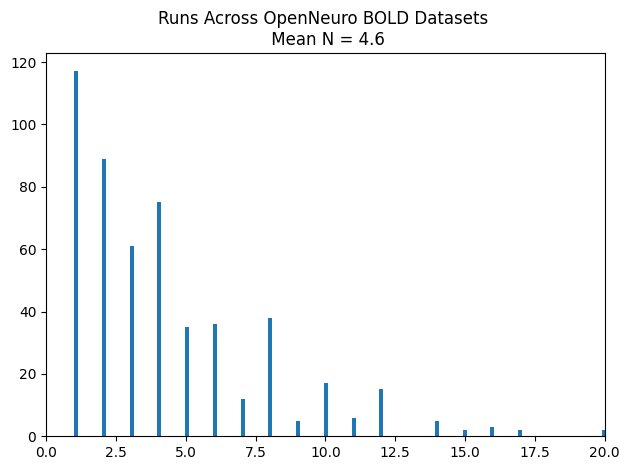

In [15]:
filtered_data['num_runs'] = filtered_data['num_runs'].fillna(0).astype(int)

plt.hist(filtered_data['num_runs'], bins=500)
max_run = filtered_data['num_runs'].max()
max_label = filtered_data.loc[filtered_data['num_runs'] == max_run, 'study_name'].values[0]
plt.xlim(0,20)
plt.title(f'Runs Across OpenNeuro BOLD Datasets \n Mean N = {filtered_data["num_runs"].mean().round(1)}')
plt.tight_layout()
plt.show()

In [16]:
check_levels_miss_str = 'Levels key missing in data descriptor'
string_levels_col = 'string_unique_in_levels'
missing_levels_df = final_combined_df[(final_combined_df['data_type'] == 'object') & (final_combined_df['column_in_descriptor'] == True)]
missing_levels_df = missing_levels_df[
    ~(
        missing_levels_df['events_column'].str.contains('path|file', case=False, na=False) |
        missing_levels_df['string_unique'].str.contains('\.bmp|\.jpg|\.wav', case=False, na=False)
    )
]

missing_levels_df[string_levels_col].apply(lambda x: x == check_levels_miss_str).sum() / len(missing_levels_df)


0.6833699998086966

In [17]:
col_descr_df = final_combined_df[
    ~(
        final_combined_df['events_column'].str.contains('path|file', case=False, na=False) |
        final_combined_df['string_unique'].str.contains('\.bmp|\.jpg|\.wav', case=False, na=False)
    )
]

col_descrfalse_df = final_combined_df[final_combined_df['column_in_descriptor'] == False]
col_descrfalse_df = col_descrfalse_df[
    ~(
        col_descrfalse_df['events_column'].str.contains('path|file', case=False, na=False) |
        col_descrfalse_df['string_unique'].str.contains('\.bmp|\.jpg|\.wav', case=False, na=False)
    )
]

In [18]:
study_ids = missing_levels_df['study'].unique()

prop_misslevels_df = []

for op_study in study_ids:
    study_subs = missing_levels_df[missing_levels_df['study'] == op_study]['subject'].unique()
    rand_sub = random.choice(study_subs)



    sub_vals = missing_levels_df[
        (missing_levels_df['study'] == op_study) &
        (missing_levels_df['subject'] == rand_sub)
    ]
    prop_miss_levels = sub_vals[string_levels_col].apply(lambda x: 
                                                         x == check_levels_miss_str).sum() / len(sub_vals)
    prop_misslevels_df.append(prop_miss_levels)

In [19]:
study_ids = col_descr_df['study'].unique()
prop_missldescr_df = []
for op_study in study_ids:
    study_subs = col_descr_df[col_descr_df['study'] == op_study]['subject'].unique()
    rand_sub = random.choice(study_subs)

    sub_vals = col_descr_df[
        (col_descr_df['study'] == op_study) &
        (col_descr_df['subject'] == rand_sub)
    ]
    prop_miss_decsr = sub_vals['column_in_descriptor'].apply(lambda x: 
                                                         x == False).sum() / len(sub_vals)
    prop_missldescr_df.append(prop_miss_decsr)


/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_54522/3950480675.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=prop_missldescr_df, palette='viridis')


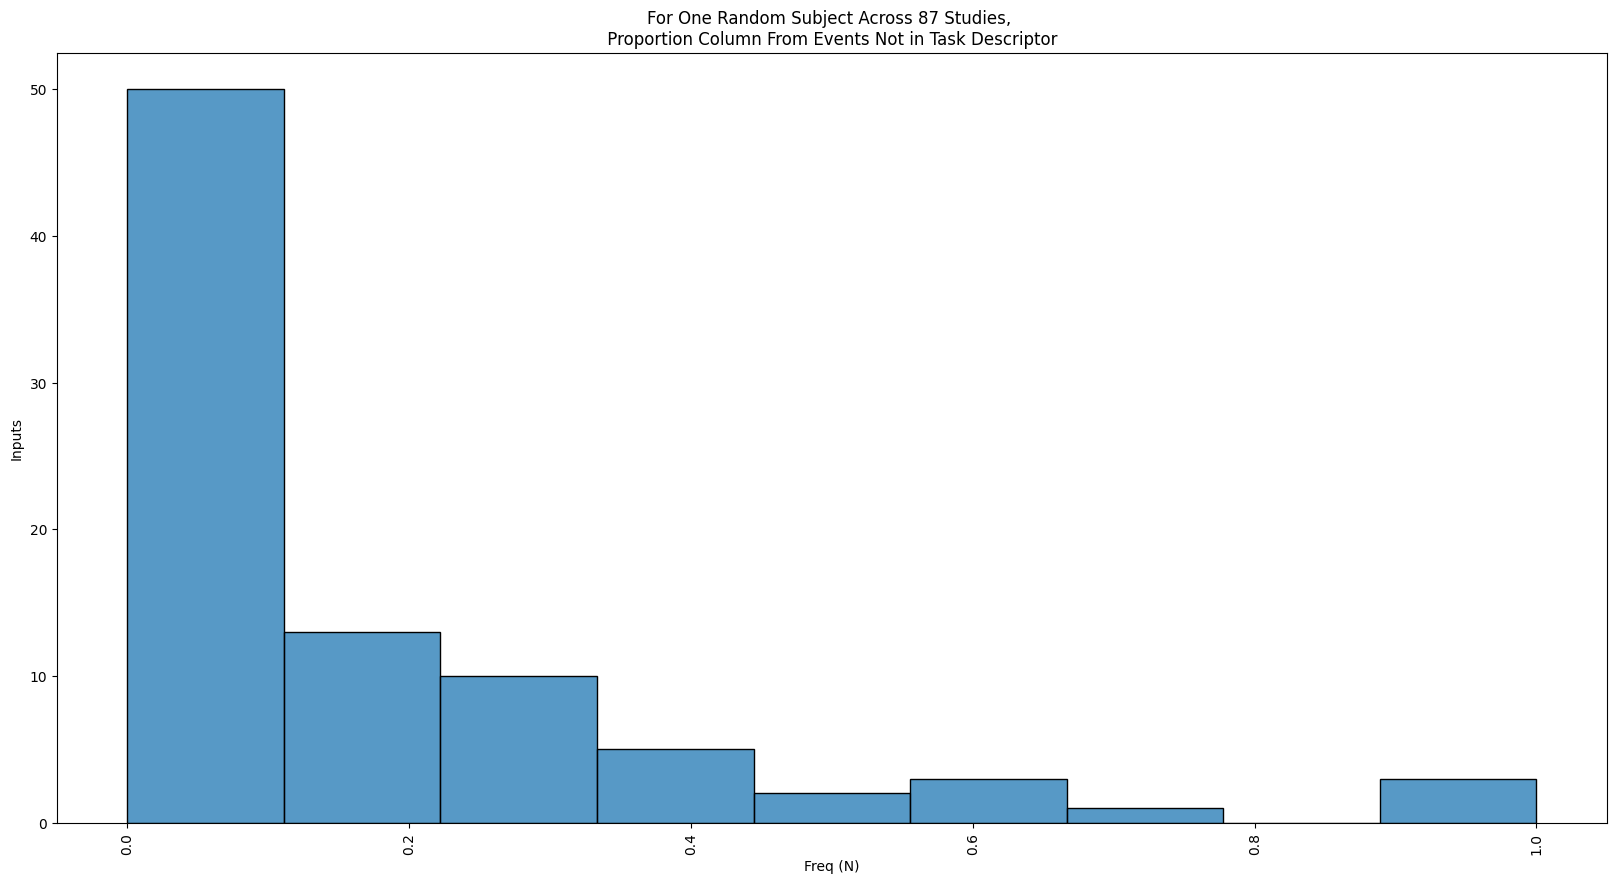

In [20]:

plt.figure(figsize=(20, 10))
sns.histplot(data=prop_missldescr_df, palette='viridis')
plt.title(f'For One Random Subject Across {len(study_ids)} Studies, \n Proportion Column From Events Not in Task Descriptor ')
plt.xticks(rotation=90)
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_54522/3062419620.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=prop_misslevels_df, palette='viridis')


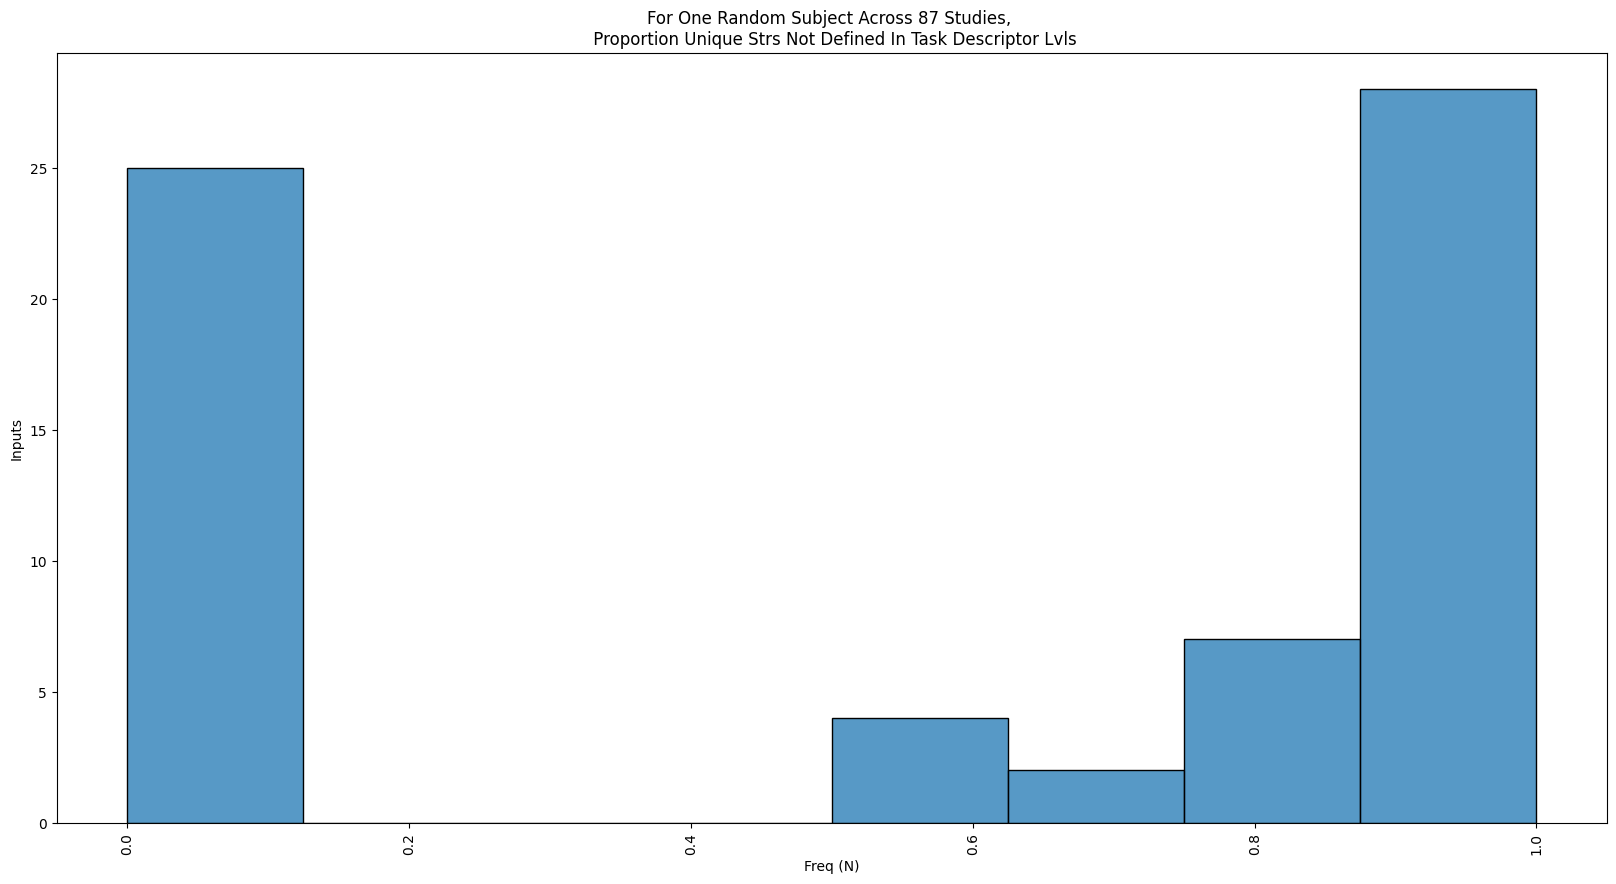

In [21]:
plt.figure(figsize=(20, 10))
sns.histplot(data=prop_misslevels_df, palette='viridis')
plt.title(f'For One Random Subject Across {len(study_ids)} Studies, \n Proportion Unique Strs Not Defined In Task Descriptor Lvls')
plt.xticks(rotation=90)
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

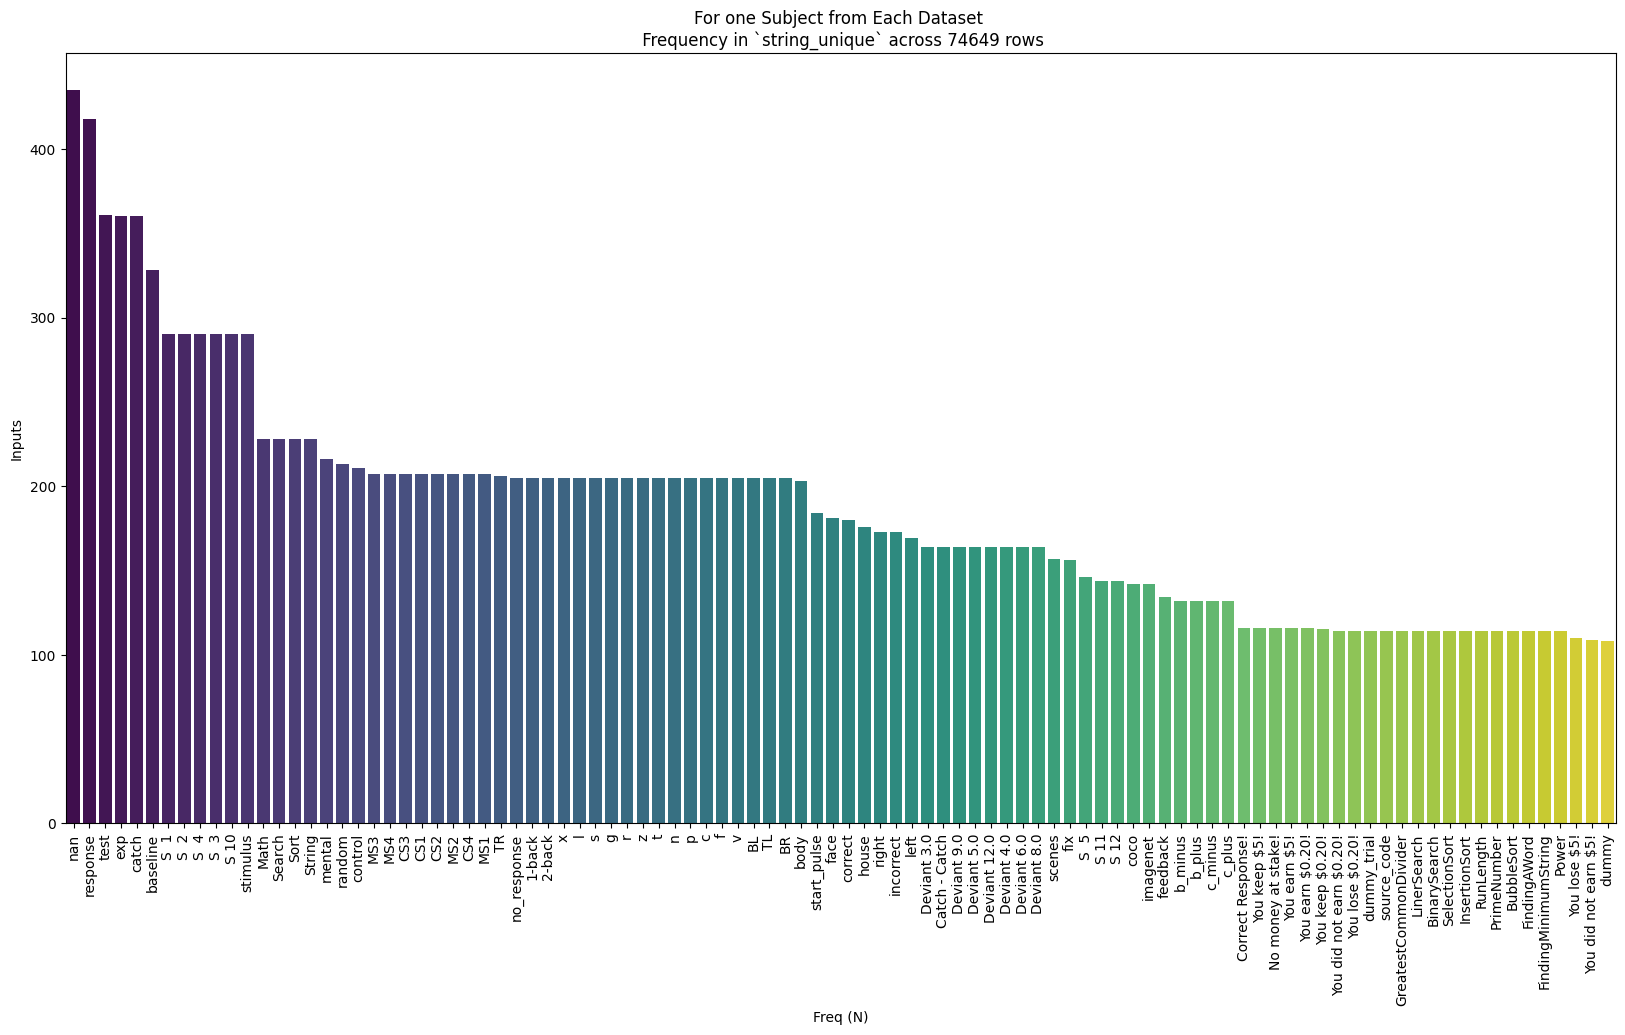

In [22]:
def select_random_subject(df):
    selected_subjects = df.groupby('study')['subject'].apply(lambda x: x.sample(n=1).values[0])
    filtered_df = df[df['subject'].isin(selected_subjects)]
    return filtered_df
col_descr_subsetdf = select_random_subject(col_descr_df)

freq_words = Counter(col_descr_subsetdf['string_unique'])

# pick top 100
top_words = dict(freq_words.most_common(100))

top_words_df = pd.DataFrame(list(top_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(20, 10))
sns.barplot(data=top_words_df, x='name', y='freq', palette='viridis')
plt.title(f'For one Subject from Each Dataset \n Frequency in `string_unique` across {len(col_descr_subsetdf)} rows')
plt.xticks(rotation=90)
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

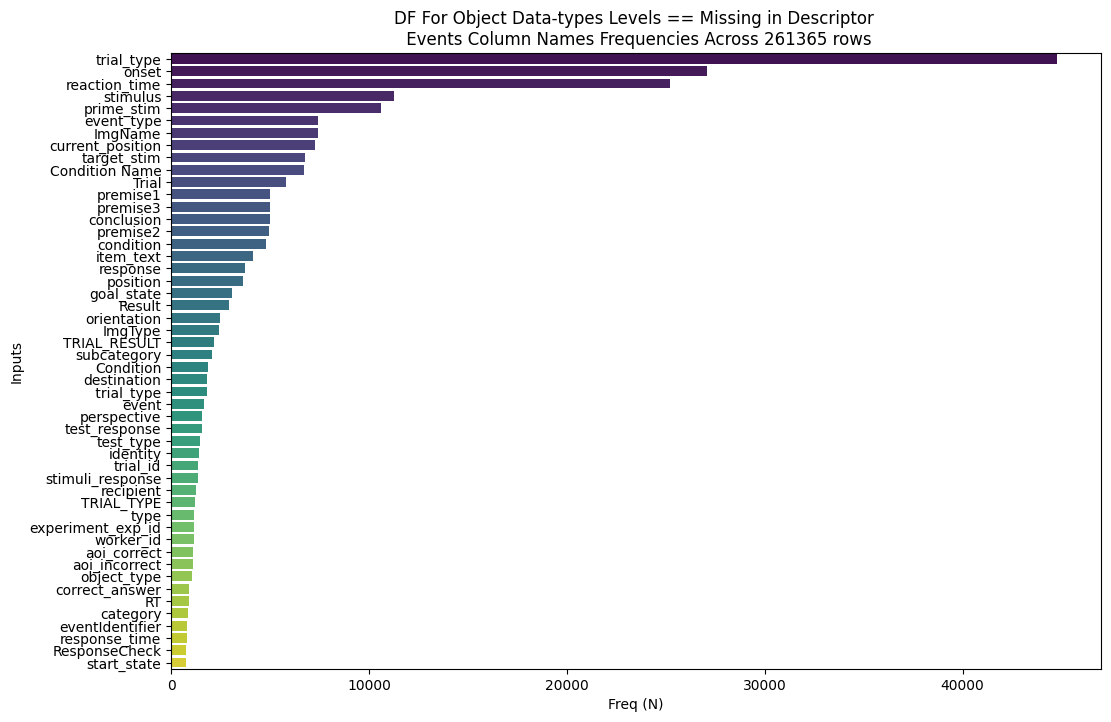

In [23]:
freq_words = Counter(missing_levels_df['events_column'])

# pick top 50
top_words = dict(freq_words.most_common(50))

top_words_df = pd.DataFrame(list(top_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'DF For Object Data-types Levels == Missing in Descriptor \n Events Column Names Frequencies Across {len(missing_levels_df)} rows')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

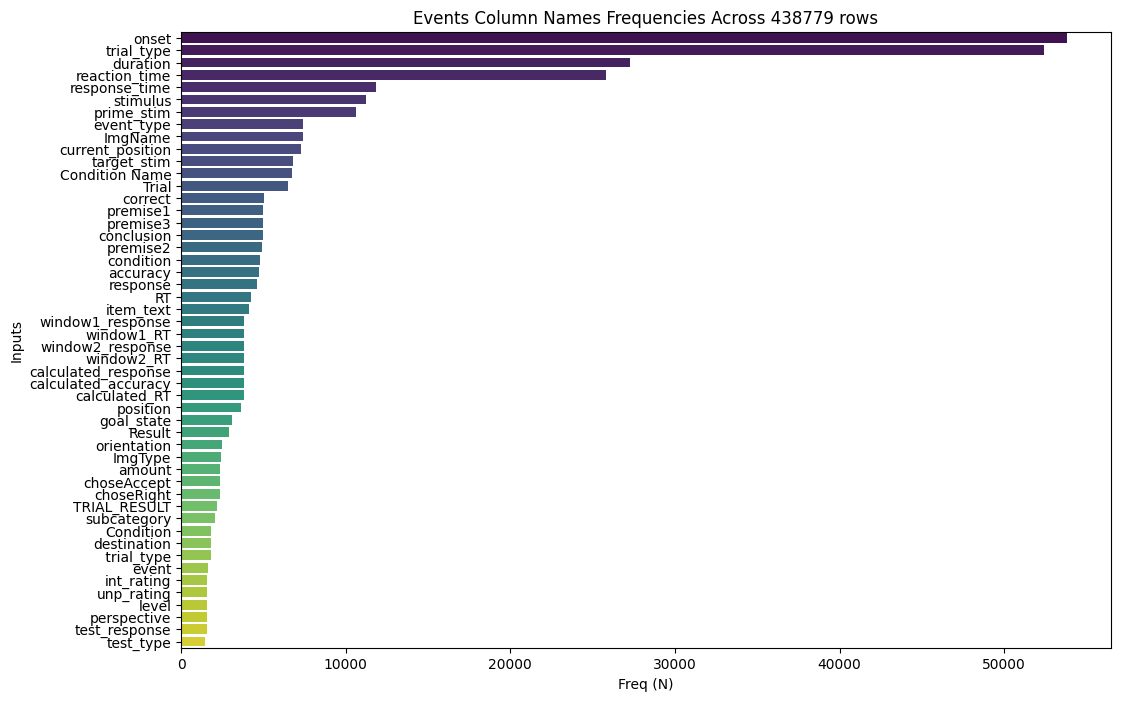

In [24]:
freq_words = Counter(col_descr_df['events_column'])

# pick top 50
top_words = dict(freq_words.most_common(50))

top_words_df = pd.DataFrame(list(top_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Events Column Names Frequencies Across {len(col_descr_df)} rows')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

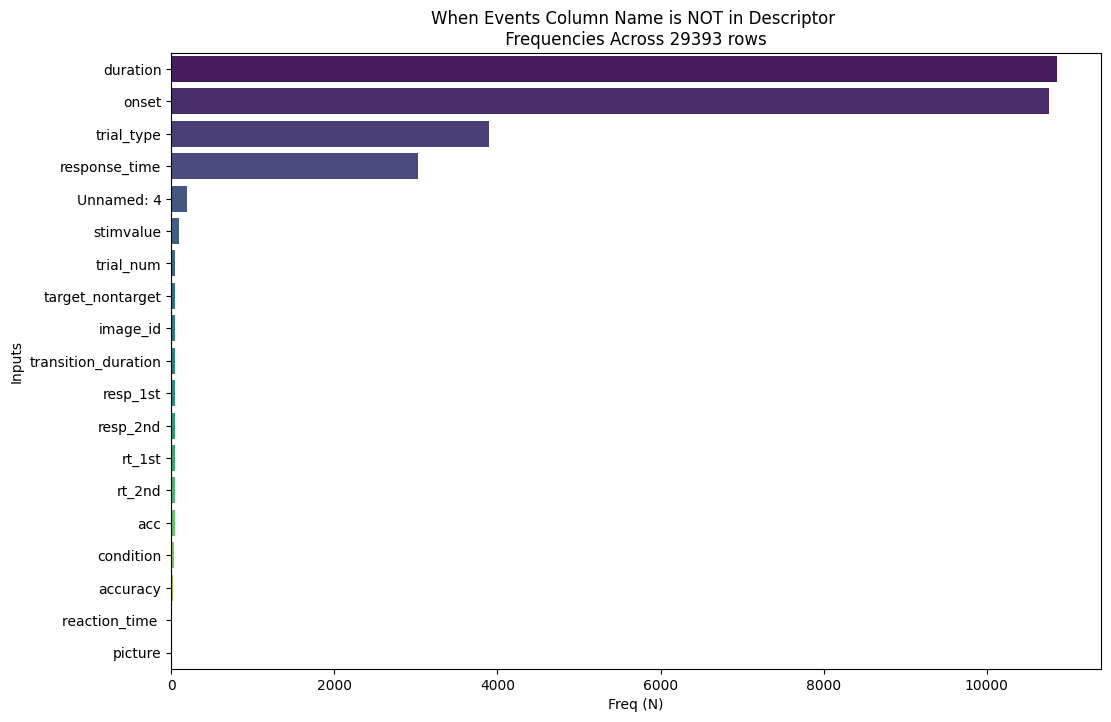

In [25]:
freq_words = Counter(col_descrfalse_df['events_column'])

# pick top 50
top_words = dict(freq_words.most_common(50))

top_words_df = pd.DataFrame(list(top_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'When Events Column Name is NOT in Descriptor \n Frequencies Across {len(col_descrfalse_df)} rows ')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

# Test odd outputs

In [3]:
tst_df = '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds002674/'
tst_layout = BIDSLayout(tst_df)

In [5]:
tst_layout.get_sessions(), tst_layout.get_runs()

(['01',
  '06',
  '56',
  '08',
  '27',
  '10',
  '18',
  '19',
  '51',
  '39',
  '50',
  '33',
  '52',
  '35',
  '38',
  '47',
  '11',
  '05',
  '07',
  '24',
  '44',
  '36',
  '46',
  '21',
  '29',
  '25',
  '02',
  '03',
  '13',
  '49',
  '32',
  '12',
  '37',
  '43',
  '30',
  '45',
  '54',
  '26',
  '48',
  '17',
  '31',
  '55',
  '58',
  '23',
  '60',
  '22',
  '16',
  '59',
  '40',
  '34',
  '04',
  '42',
  '53',
  '09',
  '41',
  '20',
  '28',
  '57',
  '14',
  '15'],
 [])